In [0]:
%matplotlib inline
import torchvision.datasets as dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [0]:
class ConfigClass():
    train_dir = './Siamese Networks/data/faces/training/'
    test_dir = './Siamese Networks/data/faces/testing/'   
    train_batch_size = 64
    train_num_epochs = 100

In [0]:
class SiameseDataset(Dataset):
    
    def __init__(self, image_folder, transform = None, invert = False):
        self.image_folder = image_folder
        self.transform = transform
        self.invert = invert
        
    def __getitem__(self, index):
        sample_1 = random.choice(self.image_folder.imgs)
        same_class = random.randint(0, 1)
        
        if same_class:
            while True:
                sample_2 = random.choice(self.image_folder.imgs)
                if sample_1[1] == sample_2[1]:
                    break
        else:
            while True:
                sample_2 = random.choice(self.image_folder.imgs)
                if sample_1[1] != sample_2[1]:
                    break
        
        img_1 = Image.open(sample_1[0]).convert("L")
        img_2 = Image.open(sample_2[0]).convert("L")
        
        if self.invert:
            img_1 = PIL.ImageOps.invert(img_1)
            img_2 = PIL.ImageOps.invert(img_2)
        
        if self.transform:
            img_1 = self.transform(img_1)
            img_2 = self.transform(img_2)
            
        return img_1, img_2, torch.from_numpy(np.array([int(sample_1[1] != sample_2[1])], dtype = np.float32))
    
    def __len__(self):
        return len(self.image_folder.imgs)

In [0]:
image_folder = dataset.ImageFolder(root=ConfigClass.train_dir)
siamese_dataset = SiameseDataset(image_folder=image_folder, 
                                 transform=transforms.Compose([transforms.Resize((100, 100)), transforms.ToTensor()]), 
                                 invert=False)

In [0]:
def imshow(img, text=None):
    np_img = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic', fontweight='bold', bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

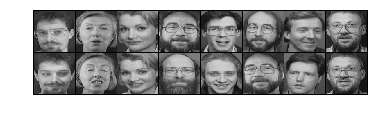

array([[0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.]], dtype=float32)

In [9]:
dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=8, batch_size=8)
data_iter = iter(dataloader)
vis_batch = next(data_iter)
merged = torch.cat((vis_batch[0], vis_batch[1]), 0)
imshow(torchvision.utils.make_grid(merged))
vis_batch[2].numpy()

In [0]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        self.reflection_pad = nn.ReflectionPad2d(1)
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=3)
        self.conv3 = nn.Conv2d(8, 8, kernel_size=3) 
        self.relu = nn.ReLU(inplace=True)
        self.batch_norm1 = nn.BatchNorm2d(4)
        self.batch_norm2 = nn.BatchNorm2d(8) 
        self.fc1 = nn.Linear(8 * 100 * 100, 500)
        self.fc2 = nn.Linear(500, 500)
        self.fc3 = nn.Linear(500, 5)
        
    def forward_one_branch(self, x):
        x = self.batch_norm1(self.relu(self.conv1(self.reflection_pad(x))))
        x = self.batch_norm2(self.relu(self.conv2(self.reflection_pad(x))))        
        x = self.batch_norm2(self.relu(self.conv3(self.reflection_pad(x))))   
        x = x.view(x.size()[0], -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))        
        x = self.fc3(x)
        
        return x
        
    def forward(self, input1, input2):
        output1 = self.forward_one_branch(input1)
        output2 = self.forward_one_branch(input2)     
        
        return output1, output2

In [0]:
class ConstrastiveLoss(torch.nn.Module):
    
    def __init__(self, margin=2.0):
        super(ConstrastiveLoss, self).__init__()
        self.margin = margin
        
    def forward(self, output1, output2, label):
        distance = F.pairwise_distance(output1, output2, keepdim=True)
        contrastive_loss = torch.mean((1 - label)*torch.pow(distance, 2)
                                      + (label)*torch.pow(torch.clamp(self.margin - distance, min=0.0), 2))
        
        return contrastive_loss

In [0]:
dataloader = DataLoader(siamese_dataset, shuffle=True, num_workers=8, batch_size=ConfigClass.train_batch_size)
model = SiameseNetwork().cuda()
criterion = ConstrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

counter = []
loss_history = []
iteration = 0

Epoch: 0 	 Loss: 0.6408650279045105
Epoch: 1 	 Loss: 0.4406752288341522
Epoch: 2 	 Loss: 0.3259865641593933
Epoch: 3 	 Loss: 0.3066266179084778
Epoch: 4 	 Loss: 0.14611424505710602
Epoch: 5 	 Loss: 0.09340031445026398
Epoch: 6 	 Loss: 0.10551183670759201
Epoch: 7 	 Loss: 0.0905471220612526
Epoch: 8 	 Loss: 0.08013607561588287
Epoch: 9 	 Loss: 0.08443757891654968
Epoch: 10 	 Loss: 0.11275379359722137
Epoch: 11 	 Loss: 0.04117581993341446
Epoch: 12 	 Loss: 0.031731292605400085
Epoch: 13 	 Loss: 0.0374688059091568
Epoch: 14 	 Loss: 0.03865113854408264
Epoch: 15 	 Loss: 0.02474866434931755
Epoch: 16 	 Loss: 0.033996179699897766
Epoch: 17 	 Loss: 0.01978778839111328
Epoch: 18 	 Loss: 0.02917812019586563
Epoch: 19 	 Loss: 0.038073062896728516
Epoch: 20 	 Loss: 0.019850771874189377
Epoch: 21 	 Loss: 0.01717621460556984
Epoch: 22 	 Loss: 0.03386085852980614
Epoch: 23 	 Loss: 0.0316968709230423
Epoch: 24 	 Loss: 0.03976994380354881
Epoch: 25 	 Loss: 0.022196341305971146
Epoch: 26 	 Loss: 0.0305

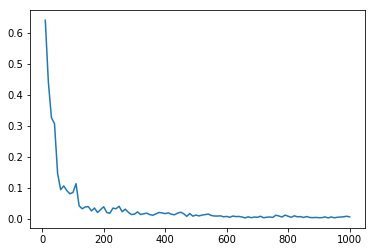

In [18]:
for epoch in range(ConfigClass.train_num_epochs):
    for i, data in enumerate(dataloader, 0):
        input1, input2, label = data
        input1, input2, label = input1.cuda(), input2.cuda(), label.cuda()
        optimizer.zero_grad()
        output1, output2 = model(input1, input2)
        contrastive_loss = criterion(output1, output2, label)
        contrastive_loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print("Epoch: {} \t Loss: {}".format(epoch, contrastive_loss.item()))
            iteration += 10
            loss_history.append(contrastive_loss.item())
            counter.append(iteration)
            
show_plot(counter, loss_history)

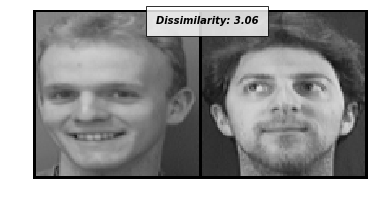

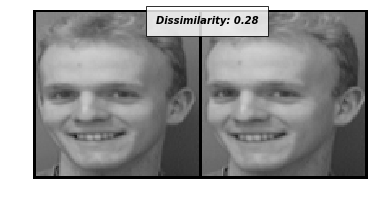

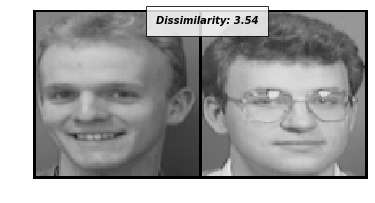

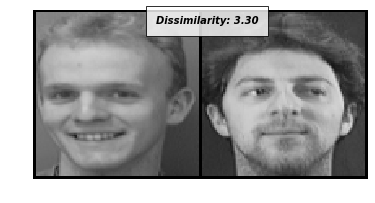

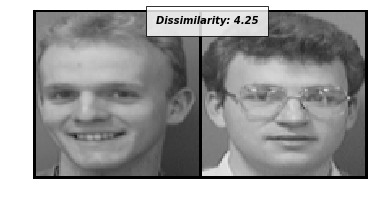

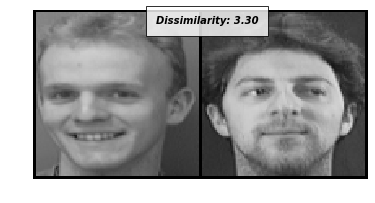

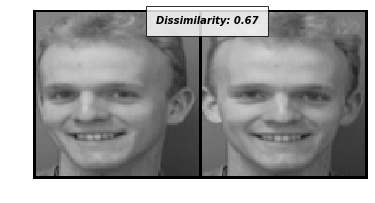

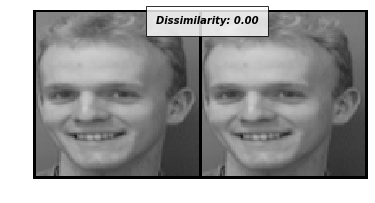

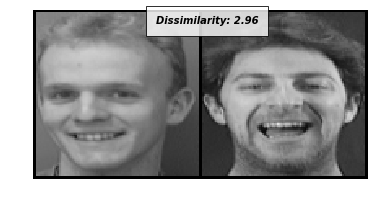

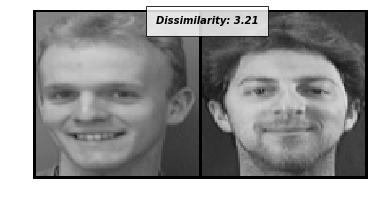

In [20]:
test_folder = dataset.ImageFolder(root=ConfigClass.test_dir)
siamese_dataset = SiameseDataset(image_folder=test_folder, 
                                 transform=transforms.Compose([transforms.Resize((100, 100)), transforms.ToTensor()]), 
                                 invert=False)

dataloader = DataLoader(siamese_dataset, num_workers=6, batch_size=1, shuffle=True)
data_iter = iter(dataloader)
img0, _, _ = next(data_iter)

for i in range(10):
    _, img1, label = next(data_iter)
    merged = torch.cat((img0,img1), 0)
    
    output1, output2 = model(Variable(img0).cuda(), Variable(img1).cuda())
    distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(merged), 'Dissimilarity: {:.2f}'.format(distance.item()))